## Proba-V Time-Series Analysis
**Author:** René Kopeinig<br>
**Description:** Basic Time-Series Analysis using Proba-V NDVI (Normalized Difference Vegetation Index) imagery.

In [1]:
%matplotlib inline

In [4]:
from IPython.display import Image
import ee, datetime
import pandas as pd
import numpy as np
from pylab import *
import seaborn as sns
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

ee.Initialize()

### Load Proba-V image collection and point geometry
Selected Location of point is from the Proba-V Footprint X18Y02 in Luxembourg, Europe. 

In [5]:
# Set start and end date
startTime = datetime.datetime(2015, 1, 1)
endTime = datetime.datetime(2017, 12, 31)

# Create image collection
collection = ee.ImageCollection('VITO/PROBAV/C1/S1_TOC_100M').filterDate(startTime, endTime)
# Create point in Luxembourg (Proba-V Footprint: X18Y02)
point = {'type':'Point', 'coordinates':[6.134136, 49.612485]};

### Retrieve information, reshape and calculate NDVI
Retrieving information from point geometry with a buffer of 500m over image collection. Reshaping data and calculating NDVI from **RED** and **NIR** band.

In [6]:
info = collection.getRegion(point,500).getInfo()

In [7]:
# Reshape image collection 
header = info[0]
data = array(info[1:])

iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

# List of used image bands
band_list = ['RED',u'NIR']

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float64)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)

### Reshape NDVI array into Pandas Dataframe

In [8]:
df = pd.DataFrame(data=ndvi, index=list(range(len(ndvi))), columns=['NDVI'])
df = df.interpolate()
df['Date'] = pd.Series(time, index=df.index)
df = df.set_index(df.Date)
df.index = pd.to_datetime(df.index)
df['NDVI']=df['NDVI'].fillna(0)

### Obtain statistical information over all elements of the Time-Series

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2015-01-01 01:00:00 to 2017-12-30 01:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   NDVI    1095 non-null   float64       
 1   Date    1095 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 25.7 KB


In [10]:
df.describe()

,NDVI,Date
count,1095.000000,1095
mean,0.160483,2016-07-01 01:35:17.260273920
min,-0.126732,2015-01-01 01:00:00
25%,0.032620,2015-10-01 14:00:00
50%,0.105028,2016-07-01 02:00:00
75%,0.262667,2017-03-31 14:00:00
max,0.633987,2017-12-30 01:00:00
std,0.160598,NaN


### Visualize Proba-V NDVI Time Series

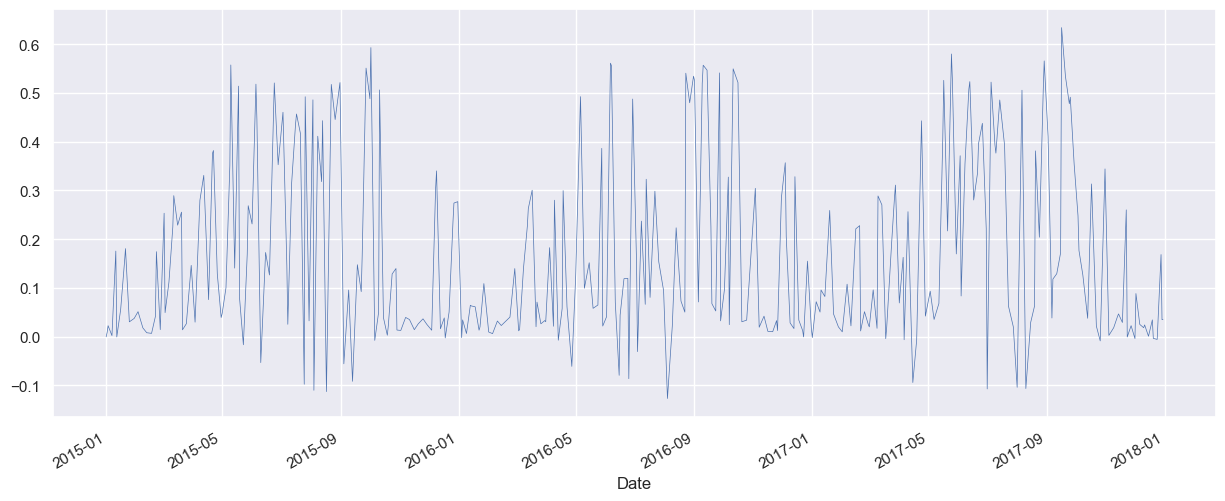

In [11]:
sns.set(rc={'figure.figsize':(15, 6)})
df['NDVI'].plot(linewidth=0.5);

### Seasonal Decomposition

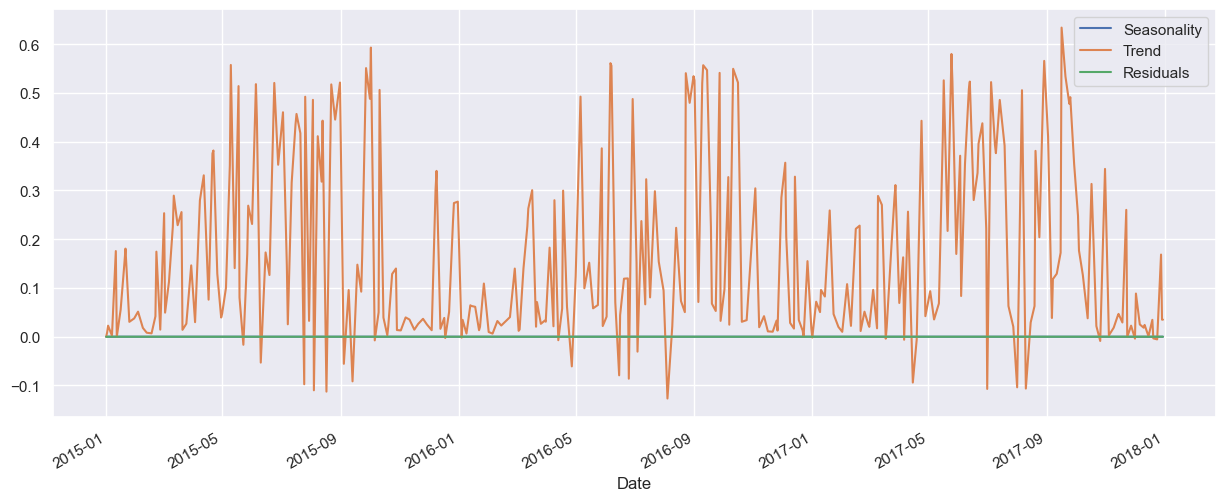

In [16]:
sd=seasonal_decompose(df['NDVI'], model='additive', period=1)

sd.seasonal.plot()
sd.trend.plot()
sd.resid.plot()
plt.legend(['Seasonality', 'Trend', 'Residuals'])

### Resample data
Resampling to weekly level and calculate the percentage change over one year.

Text(0.5, 1.0, '52 Weeks Percentage Change')

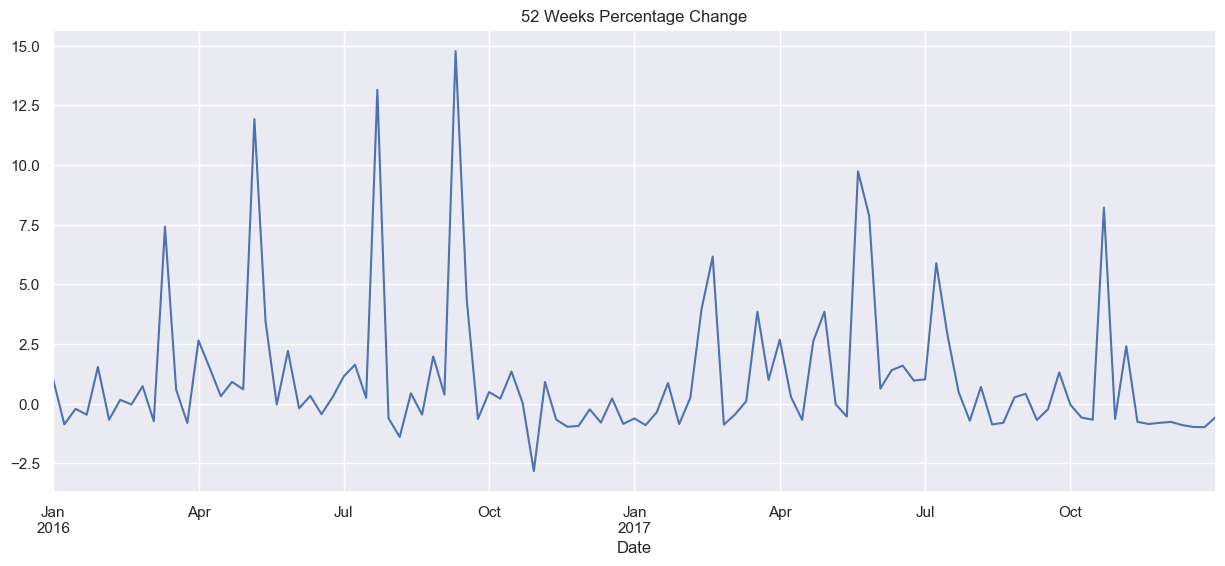

In [28]:
df_weekly=df.resample('W').mean()[['NDVI']]
df_weekly['pct_change'] = df_weekly.pct_change(12)
df_weekly['pct_change']['2016':].plot()
plt.title('52 Weeks Percentage Change')